In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from kadi import events
from mica.archive import aca_l0, aca_dark
from Ska.Matplotlib import plot_cxctime, cxctime2plotdate
from astropy.table import Table, unique
from chandra_aca.aca_image import ACAImage
import os.path

## Goal ##

Estimate number of new bad pixels that could be detected dynamically in the ACA level 0 data in the time periods between the ACA DCC measurements.

## Algorithm ##
* Cycle through all level 0 ACA images and for each image get the corresponding section of the most recent ACA DCC map.
* Search for pixels with value exceeding 1500 e-/sec in each ACA DCC section.
* If a warm pixel is found, store:
    1. Pixel's location (row, col)
    2. Obsid
    3. Slot
    4. Current DCC value (2017/092)
    5. Value from the previous ACA DCC measurent (2017/011)
    6. Status (new/old)
    
__Notes__
* Check all pixels sampled by ACA, not only the 8x8 or 6x6 edge.
* Readout windows with FIDs also included in the footprint.
* 6x6 or 8x8 corner pixels are not telemetered but with the current code their locations are included in the footprint.

## ACA CCD coordinate system for reference ##

<img src='ACA_coordinates_ACAImage.jpg' width='400'>

In [2]:
# Previous and current ACA DCC maps
dccimg_previous = aca_dark.dark_cal.get_dark_cal_image('2017:010', select='nearest', aca_image=True)
dccimg_current = aca_dark.dark_cal.get_dark_cal_image('2017:092', select='nearest', aca_image=True)

In [3]:
# Get all dwells in the time period between the previous and current ACA DCC
dwells = events.dwells.filter('2017:011', '2017:092')

In [4]:
foot_file = 'foot-Q1-2017.dat'
hot_pixel_file = 'hp-Q1-2017-gt1500.dat'
threshold = 1500 # e-/sec

if not os.path.isfile(hot_pixel_file):

    lines = []
    foot = ACAImage(np.zeros((1024, 1024)), row0=-512, col0=-512)

    for d in dwells:        
        for slot in range(8):

            slot_imgs = aca_l0.get_l0_images(d.start, d.stop, slot=slot)        

            for img in slot_imgs:

                foot[img] = 1
                section_previous = dccimg_previous[img]
                section_current = dccimg_current[img]
                r, c = np.nonzero(section_current > threshold)

                for rr, cc in zip(r, c):
                    row = img.row0 + rr
                    col = img.col0 + cc
                    line = {'obsid': d.get_obsid(), 'slot': slot,
                            'row': row, 'col': col, 'status': 'new',
                            'dcc_current': section_current[rr, cc],
                            'dcc_previous': section_previous[rr, cc]}
                    if section_previous[rr, cc] > threshold:
                        line['status'] = 'old'                        
                    if line not in lines:
                        lines.append(line)

    # Save footprint
    np.savetxt(foot_file, foot, fmt='%4i')
    # Save hot pixels
    t = Table(lines)
    t.write(hot_pixel_file, format='ascii')
    
else:
    
    foot = np.loadtxt(foot_file)
    t = Table.read(hot_pixel_file, format='ascii')

In [5]:
print(t.colnames)

['col', 'dcc_current', 'dcc_previous', 'obsid', 'row', 'slot', 'status']


In [6]:
thp = unique(t, keys=['row', 'col', 'status'])
print('Unique bad pixels: {}'.format(len(thp)))

Unique bad pixels: 120


In [7]:
print(thp['row', 'col', 'obsid', 'slot', 'dcc_current', 'dcc_previous', 'status'])

row  col  obsid slot dcc_current dcc_previous status
---- ---- ----- ---- ----------- ------------ ------
-476   83 50295    6      2609.0         31.0    new
-473   14 19525    7      1926.0       1479.0    new
-472 -208 50366    5      2039.0       1349.0    new
-471  354 50370    6      1840.0       1204.0    new
-468  378 50219    7      1587.0       1460.0    new
-461 -445 18944    7      2622.0       2009.0    old
-459  129 50305    7      1829.0       1364.0    new
-447  244 18969    3      2351.0       2017.0    old
-443  -64 50239    1      2298.0       1712.0    old
-430 -143 50233    1      1748.0       1203.0    new
 ...  ...   ...  ...         ...          ...    ...
 399  237 50277    4      1757.0       1314.0    new
 414   46 50210    0      1721.0       1204.0    new
 415   53 50210    0      1649.0       1082.0    new
 419 -213 50198    6      2032.0       1514.0    old
 422 -361 19863    5      1602.0       1150.0    new
 452 -285 50237    3      1820.0        856.0 

## New / old bad pixels ##

In [8]:
ok4 = thp['dcc_previous'] <= 2000
print('\n{:3d} pixels with > 1500 e-/sec in current DCC, and <= 2000 e-/sec in previous DCC'.format(len(thp[ok4])))

# Marked in red
ok2 = thp['dcc_current'] > 2000
ok1 = thp['dcc_previous'] <= 2000
print('{:3d} pixels with > 2000 e-/sec in current DCC, and <= 2000 e-/sec in previous DCC'.format(len(thp[ok1 * ok2])))

ok3 = thp['status'] == 'new'
print('\n{:3d} pixels with > 1500 e-/sec in current DCC, and <= 1500 e-/sec in previous DCC'.format(len(thp[ok3])))

ok5 = thp['dcc_previous'] > 2000
print('\n{:3d} pixels with > 1500 e-/sec in current DCC, and > 2000 e-/sec in previous DCC'.format(len(thp[ok5])))

# Marked in green
ok6 = thp['dcc_previous'] > 2000
print('{:3d} pixels with > 2000 e-/sec in current DCC, and > 2000 e-/sec in previous DCC'.format(len(thp[ok6])))


102 pixels with > 1500 e-/sec in current DCC, and <= 2000 e-/sec in previous DCC
 39 pixels with > 2000 e-/sec in current DCC, and <= 2000 e-/sec in previous DCC

 69 pixels with > 1500 e-/sec in current DCC, and <= 1500 e-/sec in previous DCC

 18 pixels with > 1500 e-/sec in current DCC, and > 2000 e-/sec in previous DCC
 18 pixels with > 2000 e-/sec in current DCC, and > 2000 e-/sec in previous DCC


## Obsid 18983 ##

In [9]:
print('Observation prior to BSH/090 with hot pixels tracked in slots 6 and 7\n')
ok7 = thp['obsid'] == 18983
print(thp['obsid', 'slot', 'row', 'col', 'dcc_current', 'dcc_previous', 'status'][ok7])

Observation prior to BSH/090 with hot pixels tracked in slots 6 and 7

obsid slot row  col  dcc_current dcc_previous status
----- ---- ---- ---- ----------- ------------ ------
18983    7 -267 -325      2062.0       1861.0    old
18983    3   10  299      2158.0       1725.0    old
18983    6   40 -332      2708.0       1860.0    old


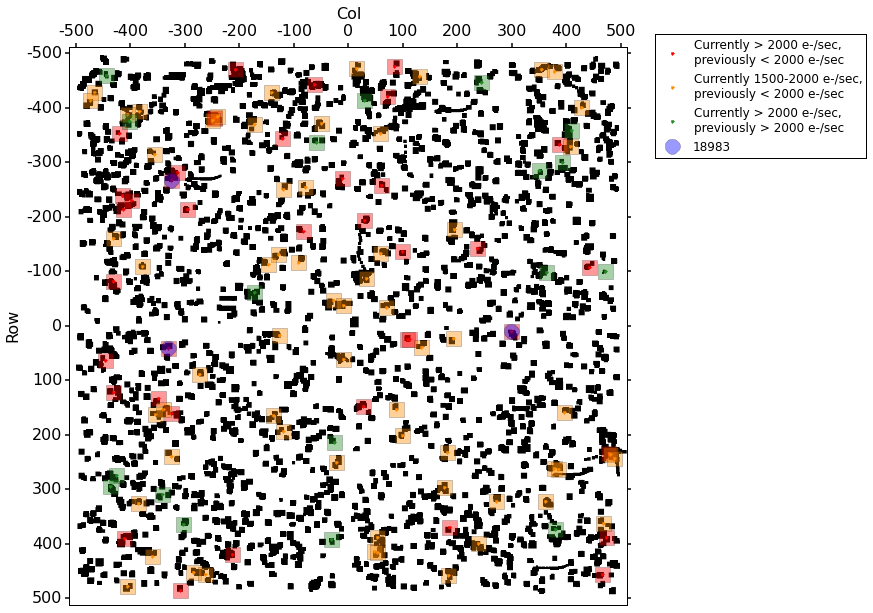

In [10]:
plt.figure(figsize=(10, 10))

plt.imshow(foot, cmap='gist_yarg')

plt.plot(thp['col'][ok1 * ok2] + 512, thp['row'][ok1 * ok2] + 512, '.',
         color='red', label='Currently > 2000 e-/sec,\npreviously < 2000 e-/sec')
plt.plot(thp['col'][ok1 * ok2] + 512, thp['row'][ok1 * ok2] + 512, 's', ms=15,
         color='red', alpha=0.4)

ok8 = thp['dcc_current'] < 2000
plt.plot(thp['col'][ok4 * ok8] + 512, thp['row'][ok4 * ok8] + 512, '.',
         color='darkorange', label='Currently 1500-2000 e-/sec,\npreviously < 2000 e-/sec')
plt.plot(thp['col'][ok4 * ok8] + 512, thp['row'][ok4 * ok8] + 512, 's', ms=15,
         color='darkorange', alpha=0.4)

plt.plot(thp['col'][ok6] + 512, thp['row'][ok6] + 512, '.',
         color='forestgreen', label='Currently > 2000 e-/sec,\npreviously > 2000 e-/sec')
plt.plot(thp['col'][ok6] + 512, thp['row'][ok6] + 512, 's', ms=15,
         color='forestgreen', alpha=0.4)

plt.plot(thp['col'][ok7] + 512, thp['row'][ok7] + 512, 'o', ms=15,
         color='blue', alpha=0.4, label='18983')

ax = plt.gca()
ax.xaxis.tick_top()
ax.set_ylabel('Row', fontsize=16)
ax.set_xlabel('Col', fontsize=16)
ax.xaxis.set_label_position('top')
ax.tick_params(direction='out', width=1.5, labelsize=16)

plt.xlim(0, 1024)
plt.ylim(1024, 0)

ticks = np.arange(12, 1112, 100)
labels = [np.str(val) for val in np.arange(-500, 600, 100)]
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)
plt.legend(loc=(1.05, 0.8), numpoints=1);

__Questions__
* What are the thin arch-like features, e.g. at (row, col) = (450, 400), (250, 400), (-250, -300), (-400, 200)?
* Lower density in the center of the image than in the corners?

In [11]:
def pixel_time_series(coords, start, stop, slot):
    """
    Retrieve pixel values as a function of time.
    :: coords :: tuple, native ACA image pixel coordinates
                 in format (row, col), e.g. (-124, 50)
    """
    vals = []
    times = []
    
    slot_imgs = aca_l0.get_l0_images(start, stop, slot=slot)
    slot_data = aca_l0.get_slot_data(start, stop, slot=slot)

    for idx, slot_img in enumerate(slot_imgs):
  
        r = coords[0] - slot_img.row0
        c = coords[1] - slot_img.col0
        
        if r in range(6) and c in range(6):
            val = (slot_img[r][c] * 5 / 1.7).astype(int)
        else:
            val = 0

        vals.append(val)
        times.append(slot_data[idx]['TIME'])
        
    return times, vals

Obsid 18983


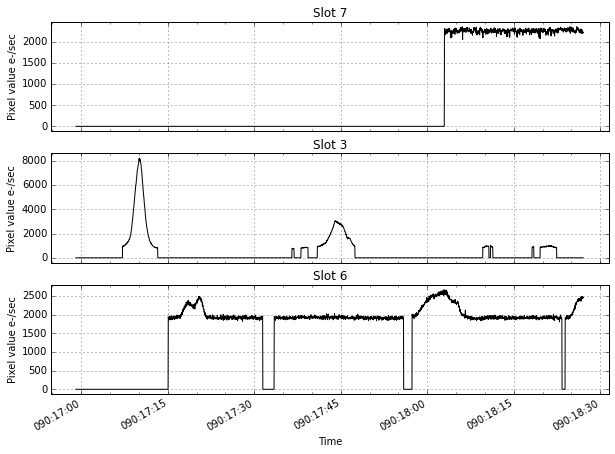

In [12]:
print('Obsid 18983')

plt.figure(figsize=(10, 10))

d = events.dwells.filter(obsid=18983)[0]

for ii, params in enumerate([(7, (-267, -325)), (3, (10, 299)), (6, (40, -332))]):
    plt.subplot(4, 1, ii + 2)
    times, vals = pixel_time_series(params[1], d.start, d.stop, params[0])
    plot_cxctime(times, vals, color='k')
    plt.grid()
    plt.margins(0.05)
    plt.xlabel('Time')
    plt.ylabel('Pixel value e-/sec')
    plt.title('Slot {:1d}'.format(params[0]));